In [1]:
%config Completer.use_jedi = False

In [80]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.VRPtest import *
from Problem.utils import *
import geoplot as gplt
import geopandas as gpd
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
# dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
# dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

evaluation_amount = {"UK25":3000,"UK50":5000,"UK75":10000}

In [81]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


amount_of_runs = 30
amount_of_evaluations = evaluation_amount[dataset[:-2]]
observer_update_interval = 60
logpath = "parameter_data/reruns2/{}".format(dataset)
try: 
    os.mkdir(logpath) 
except OSError as error: 
    print(error)
mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})

            
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}
            


In [82]:
logpath

'parameter_data/reruns2/UK75_1'

In [83]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

# NSGA-II

In [84]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_NSGAII = optimal_parameters["NSGAII"]

plot_data_NSGAII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_NSGAII = VRP(data_model_input_multi_objective)
    problem_NSGAII.name = "NSGA-II"
    problem_NSGAII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                            population_size=parameters_NSGAII["population_size"],
                            offspring_population_size=parameters_NSGAII["population_size"],
                            mutation=PermutationSwapMutation(parameters_NSGAII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator()

                               )

    performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAII])
    performance_observer_NSGAII.maxEpochs= amount_of_runs
    performance_observer_NSGAII.currentEpoch = x



    algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
    algorithm_NSGAII.run()

    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    
    store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,front_NSGAII[0])




Epoch:30 of 30
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 30} 
IGD:609.4832967407186
Best fitness: 394.3847 --- 464.6833                        
Best total fuel consumption:394.38 
Computing time: 11.05s                        
Average computing speed: 906.68it/s
Current Route:[['V1', 63, 56, 22, 53, 65, 1], ['V3', 18, 50, 23, 48, 57, 74, 33, 47, 2], ['V5', 13, 54, 34, 11, 41, 45], ['V4', 69, 24, 26, 59, 42, 67, 55, 1], ['V10', 70, 38, 52, 30, 37, 14, 44, 12, 45], ['V7', 9, 16, 51, 19, 61, 25, 7, 72, 2], ['V6', 36, 75, 17, 27, 66, 62, 5], ['V8', 43, 39, 2], ['V2', 28, 58, 2], ['V0', 3, 71, 64, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:11


In [85]:
nsga2_log_data = pd.DataFrame(plot_data_NSGAII)
nsga2_log_data.to_csv("{}/NSGA2.csv".format(logpath))

# NSGA-III

In [86]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_NSGAIII = optimal_parameters["NSGAIII"]


plot_data_NSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_NSGAIII = VRP(data_model_input_multi_objective)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII.currentEpoch =  x

    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)

    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])



nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)


Epoch:30 of 30
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20} 
IGD:614.5574838600554
Best fitness: 429.0636 --- 439.9833                        
Best total fuel consumption:429.06 
Computing time: 11.62s                        
Average computing speed: 857.16it/s
Current Route:[['V1', 63, 56, 22, 19, 61, 5], ['V3', 50, 23, 74, 48, 57, 47, 33, 18, 43, 2], ['V10', 12, 34, 54, 71, 3, 45], ['V5', 69, 24, 53, 65, 26, 42, 55, 67, 59, 1], ['V0', 70, 38, 30, 52, 41, 62, 5], ['V6', 9, 7, 51, 37, 44, 14, 11, 45], ['V7', 17, 27, 75, 66, 16, 2], ['V9', 39, 25, 72, 2], ['V2', 58, 28, 36, 2], ['V4', 13, 64, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:11


In [87]:
get_solution_results(front_NSGAIII[0],routingContext,vehicles)

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,136.022,03:14:44,2653.0,22.733681,16.713238,41.910236
1,252.307,05:18:57,4728.0,43.812482,17.364751,47.463301
2,151.792,03:19:19,3563.0,22.951292,15.120225,45.693720
3,308.196,06:30:19,4591.0,53.642498,17.405319,47.376301
4,275.548,06:06:18,2285.0,40.117270,14.559086,45.134808
5,265.706,05:06:58,3368.0,43.442998,16.350025,51.935150
6,109.854,02:48:30,2728.0,18.563712,16.898531,39.117151
7,55.138,01:24:56,1864.0,9.226981,16.734342,38.951491
8,514.071,06:57:33,1966.0,87.127995,16.948631,73.869620
9,461.603,07:19:59,3411.0,81.007636,17.549201,62.948248


In [88]:
nsga3_log_data = pd.DataFrame(plot_data_NSGAIII)
nsga3_log_data.to_csv("{}/NSGA3.csv".format(logpath))

# UNSGA-III

In [89]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_UNSGAIII = optimal_parameters["UNSGAIII"]

plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_UNSGAIII = VRP(data_model_input_multi_objective)
    problem_UNSGAIII.name = "UNSGA-III"
    problem_UNSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                            population_size=parameters_UNSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_UNSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_UNSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_UNSGAIII])
    performance_observer_UNSGAIII.maxEpochs= amount_of_runs
    performance_observer_UNSGAIII.currentEpoch =  x

    algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
    algorithm_UNSGAIII.run()

    solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
    front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)

    store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,front_UNSGAIII[0])

     
Unsga3_numerical_path = get_numerical_path(front_UNSGAIII[0].path,vehicles)

Epoch:30 of 30
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 20} 
IGD:598.9474340406571
Best fitness: 417.2137 --- 429.7333                        
Best total fuel consumption:417.21 
Computing time: 11.17s                        
Average computing speed: 891.68it/s
Current Route:[['V0', 56, 63, 19, 22, 53, 65, 1], ['V3', 43, 18, 50, 23, 74, 48, 57, 33, 47, 2], ['V5', 38, 70, 13, 34, 11, 41, 45], ['V1', 69, 24, 26, 55, 67, 30, 52, 59, 42, 1], ['V10', 54, 44, 14, 37, 12, 45], ['V9', 16, 25, 7, 39, 61, 51, 62, 5], ['V8', 17, 75, 27, 66, 72, 2], ['V6', 36, 28, 58, 2], ['V7', 9, 3, 71, 64, 45], ['V4', 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:11


In [90]:
unsga3_log_data = pd.DataFrame(plot_data_UNSGAIII)
unsga3_log_data.to_csv("{}/UNSGA3.csv".format(logpath))

# IBEA

In [91]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_IBEA = optimal_parameters["IBEA"]

plot_data_IBEA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_IBEA = VRP(data_model_input_multi_objective)
    problem_IBEA.name = "IBEA"
    problem_IBEA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_IBEA = IBEA(problem=problem_IBEA,
                            population_size=parameters_IBEA["population_size"],
                            offspring_population_size=parameters_IBEA["population_size"],
                            kappa =1,
                            mutation=PermutationSwapMutation(parameters_IBEA["mutation"]),
                            crossover=PMXCrossover(parameters_IBEA["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                               )

    performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_IBEA])
    performance_observer_IBEA.maxEpochs= amount_of_runs
    performance_observer_IBEA.currentEpoch =  x


    algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
    algorithm_IBEA.run()

    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0])

ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:30 of 30
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 20} 
IGD:609.0951519844757
Best fitness: 430.8905 --- 430.5                        
Best total fuel consumption:430.89 
Computing time: 14.69s                        
Average computing speed: 678.22it/s
Current Route:[['V0', 63, 56, 22, 19, 64, 45], ['V9', 18, 50, 23, 74, 57, 48, 53, 4], ['V2', 33, 47, 2], ['V5', 13, 12, 34, 54, 41, 45], ['V4', 70, 69, 24, 26, 42, 59, 65, 1], ['V1', 55, 67, 52, 30, 38, 44, 14, 37, 11, 45], ['V7', 66, 51, 61, 43, 25, 7, 16, 2], ['V6', 75, 27, 17, 9, 62, 3, 71, 45], ['V8', 39, 28, 58, 2], ['V3', 72, 36, 2], ['V10', 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:12


In [92]:
ibea_log_data = pd.DataFrame(plot_data_IBEA)
ibea_log_data.to_csv("{}/IBEA.csv".format(logpath))

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

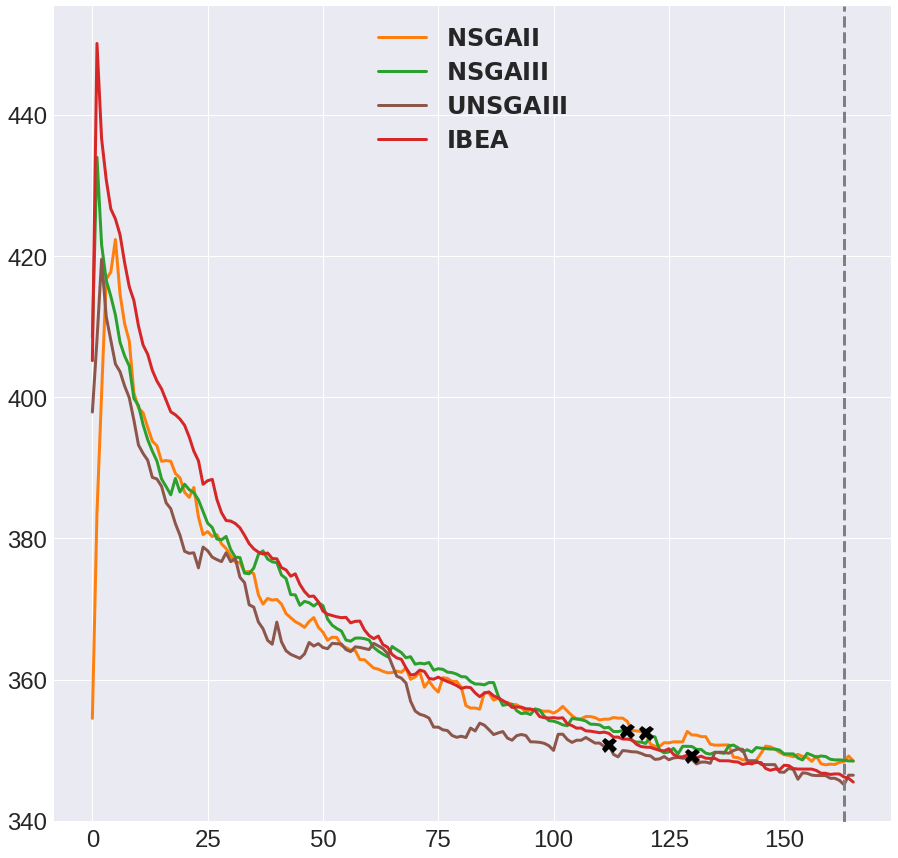

In [119]:
nsga2_curve = np.mean(plot_data_NSGAII["fuel_consumption"],axis=0)[:-1]
nsga3_curve = np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["fuel_consumption"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["fuel_consumption"],axis=0)
curves = np.array([nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =np.array(["NSGAII","NSGAIII","UNSGAIII","IBEA"])

plot_conv_curves(curves,lables)

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

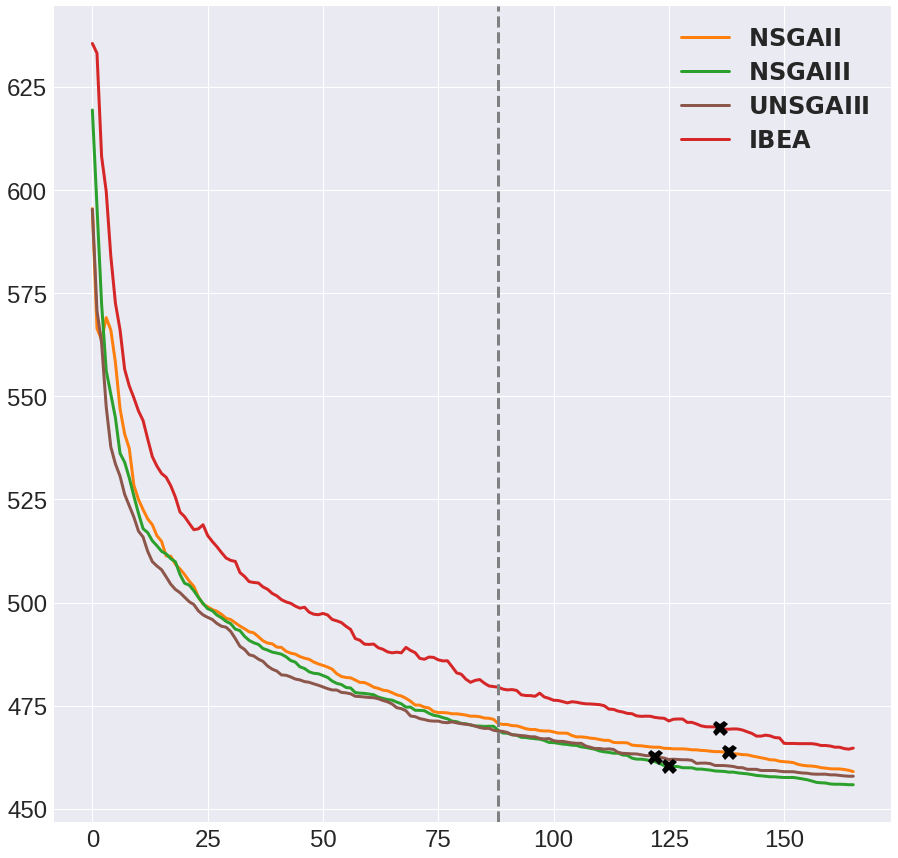

In [120]:
nsga2_curve = np.mean(plot_data_NSGAII["distance_to_origin"],axis=0)[:-1]
nsga3_curve = np.mean(plot_data_NSGAIII["distance_to_origin"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["distance_to_origin"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["distance_to_origin"],axis=0)
curves = np.array([nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables)